## Midterm 1
### Assigment 7
Author: Vojtech Orava

---------

Assigment details:

Implement the convolution of a Laplacian of a Gaussian blob (LoG) detector with an image and apply it to 3-4 images of your choice from the dataset. Do not use library functions for implementing the convolution or to generate the LoG filter. Implement your own and show the code (the interesting bits at least)! The function you implement should be able to run the LoG for different choices of the scale parameter, which is passed as an input argument. Show the results of your code on the 3-4 example images, for different choices of the scale parameter (sigma).


Dataset link: www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data

The dataset contains in the horse directory 327 pictures of horses and in the mask directory where each image correspond to one image in the horse directory, and reports the corresponding manual segmentation of the horse.

In [1]:
# importing necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
!wget -O horse003.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1i9hF_rT6aMHq0Qze5VYb_Ejt_OEiscNv'
!wget -O horse296.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1Ru8kAvTVOtWPGRqenmAfzEWbwqJ6B2RV'
!wget -O horse321.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1uuwJhtYiPMoE35-CJgskqsyhflsuPpKH'

will be placed in the single file you specified.

--2025-06-23 13:50:32--  https://drive.google.com/uc?export=download&id=1i9hF_rT6aMHq0Qze5VYb_Ejt_OEiscNv
Resolving drive.google.com (drive.google.com)... 74.125.139.113, 74.125.139.139, 74.125.139.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.139.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1i9hF_rT6aMHq0Qze5VYb_Ejt_OEiscNv&export=download [following]
--2025-06-23 13:50:32--  https://drive.usercontent.google.com/download?id=1i9hF_rT6aMHq0Qze5VYb_Ejt_OEiscNv&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107346 (105K) [image/png]
Saving to: ‘horse003.png’

horse003.png        100%[=====

The 2-D LoG function centered on zero and with Gaussian standard deviation $\sigma$ has the form:

$LoG(x,y) = - \frac{1}{\pi\sigma^4}[1-\frac{x^2 + y^2}{2\sigma^2}]e^{-\frac{x^2+y^2}{2\sigma^2}}$

Source: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

In [2]:
def LoG(sigma, size):
    """Creates LoG filter

    Args:
        sigma (double): sigma parameter for LoG
        size (double): defines kernel size (size*size)

    Returns:
        matrix of doubles: kernel matrix
    """

    # prepares matrix size
    size = int(np.ceil(size))
    if size % 2 == 0:
        size += 1

    kernel = np.zeros((size, size))
    center = size // 2

    # calculate the LoG kernel
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center # centers calculated values
            # calculates kernel based on the equation
            kernel[i, j] = (-1/(np.pi*(sigma**4)))*(1-((x**2+y**2)/(2*sigma**2)))*(np.exp(-((x**2+y**2)/(2*sigma**2))))

    # normalize the kernel
    kernel = kernel - np.mean(kernel)
    kernel = kernel / np.sum(np.abs(kernel))
    return kernel

For applying the LoG kernel, convolution is needed. Function below performs convolution on given images with given kernel.

In [3]:
def convolution(image, kernel):
    """Applies convolution of kernel to image

    Args:
        image (matrix of doubles): image to convolve on
        kernel (matrix of doubles): convolution kernel

    Returns:
        matrix of doubles: convolved image
    """

    # we nned to create image padding to be able to convolve all image
    padding_height = kernel.shape[0] // 2
    padding_width = kernel.shape[1] // 2

    padded_image = np.pad(image, ((padding_height, padding_height), (padding_width, padding_width)), mode="constant")
    result = np.zeros_like(image)

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            result[y, x] = np.sum(padded_image[y:y+kernel.shape[0], x:x+kernel.shape[1]] * kernel)

    return result

Function below calculates positions of blobs to display them. Every pixel in image is tested (convolved with different type of kernel - from biggest filter to the smallest one). Blobs positions are returned.

In [4]:
def get_blobs(images_arr, sigmas, threshold):
    """Function finds blobs in convolved image and returns their positions

    Args:
        images_arr (3D tensor - (N, X, Y)): 3D array consisting of N convolved images with resolution (X, Y)
        sigma (double array): parameters of LoG

    Returns:
        3D tensor (x,y,r): blobs positions (x,y) and radius of blob
    """

    positions = []
    h, w = images_arr[0].shape
    # loop through whole image
    for y in range(0,h,10): # step size = 10 pixels to avoid extreme overlaping of circles
        for x in range(0,w,10):
            # for each pixel we trying to find best result with biggest kernel
            # (descending order of kernels)
            for i in range(len(sigmas)-1, -1, -1):

                result = images_arr[i][y,x]
                if result >= threshold:
                    positions.append([y, x, np.sqrt(2)*sigmas[i]])
                    # if result is found, then skip to next pixel
                    break

    print(f"Number of detected blobs: {len(positions)}")
    return positions

#### Main program

Images paths, sigma values and size of the kernel are defined here. User can define a threshold for blob detection and choose if he wants to detect white/bright blobs or black/dark blobs.

12 different values of sigma are used, defined by linspace and values 2.0 and 3.0. Base size of kernel is defined as 7 and then multiples are used. User can set threshold for each image.

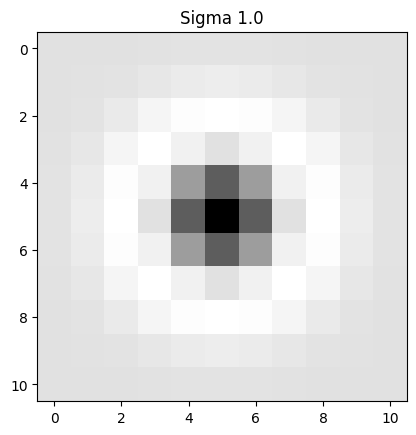

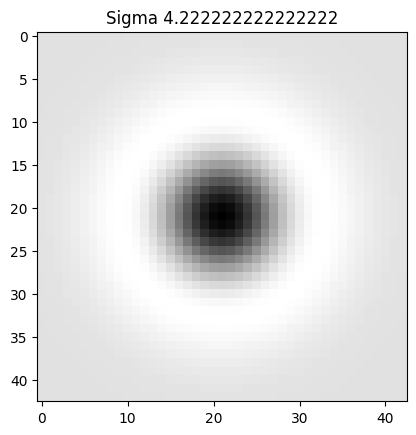

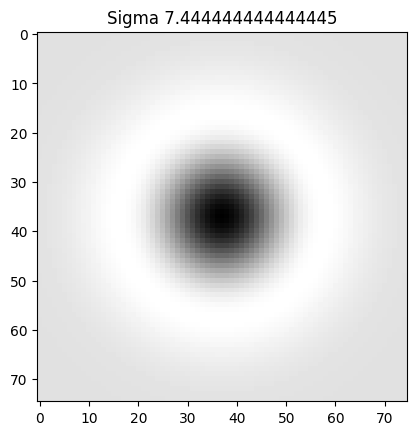

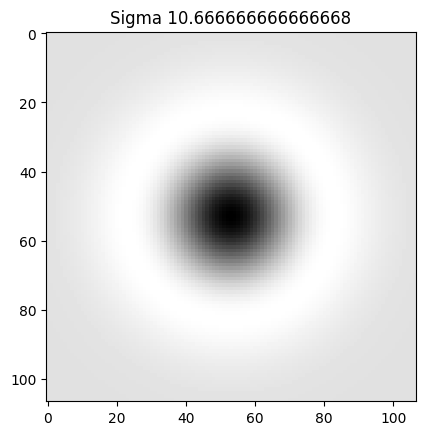

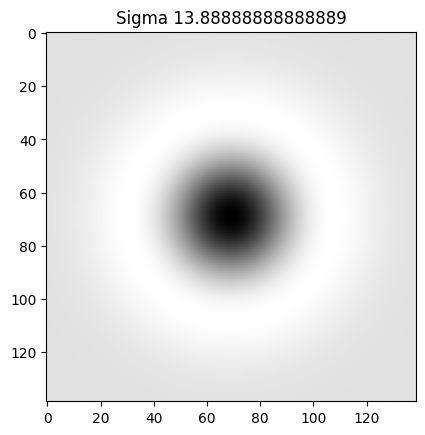

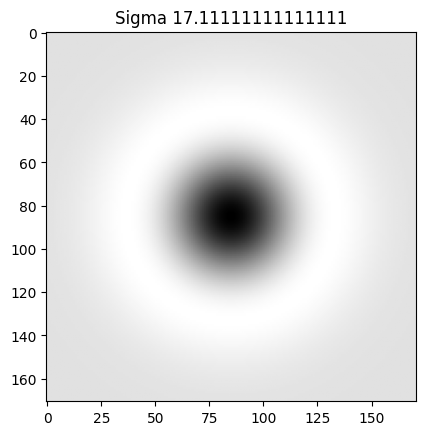

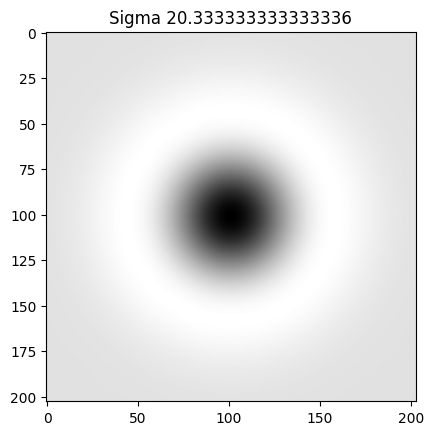

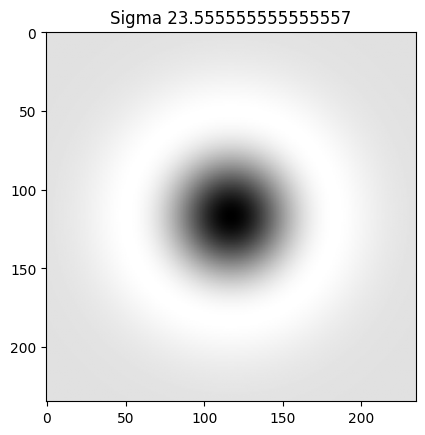

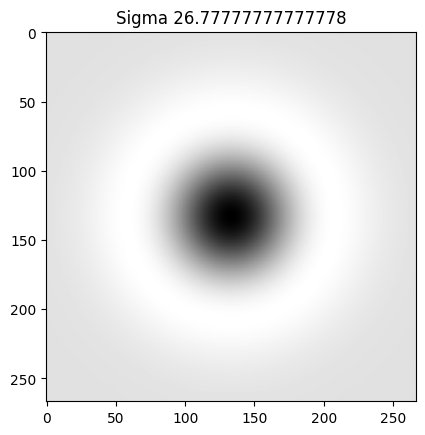

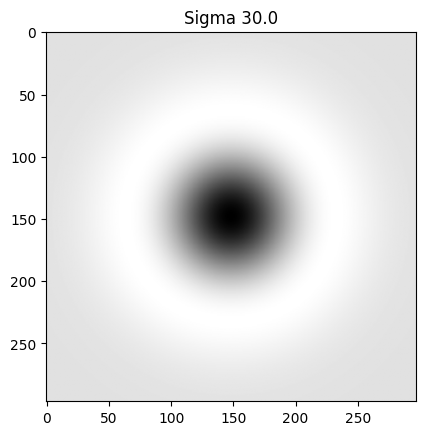

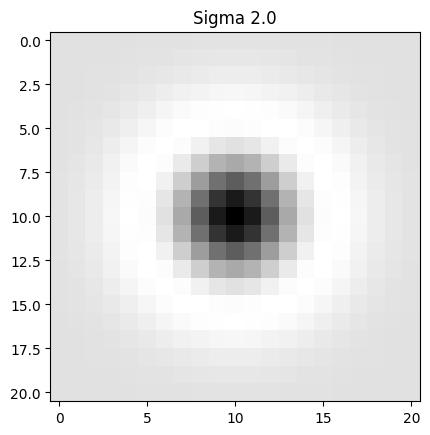

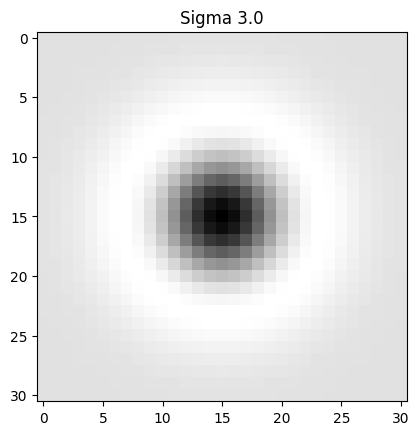

Number of detected blobs: 12
Number of detected blobs: 34
Number of detected blobs: 24


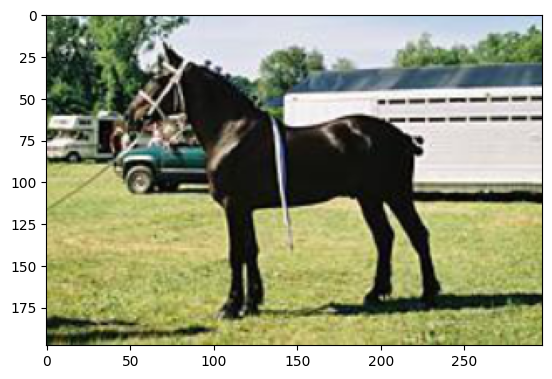

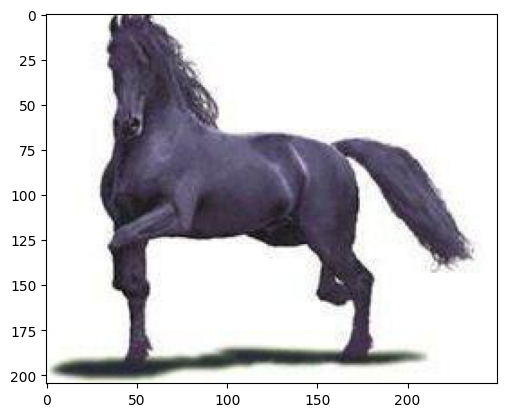

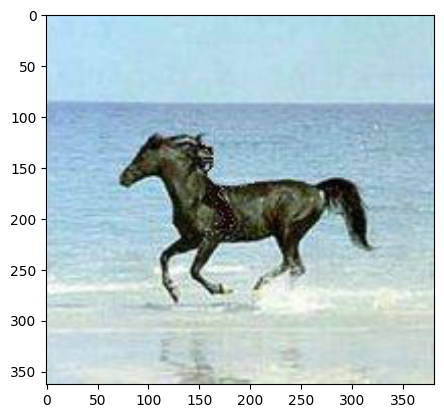

In [5]:
# IMAGES PATHS
PREFIX = "horse"
images_paths = ["003.png", "321.png", "296.png"]
images_paths = [PREFIX+x for x in images_paths]

# SETTINGS for LoG
sigmas = np.concatenate((np.linspace(1,30,10), np.array([2.0, 3.0])))
KERNELS_NUM = 7
DISPLAY_KERNELS = 1  # if true, then kernels will be plotted
DETECT_BLACK = 1   # if true, then image will be reverted and dark blobs will be detected
THRESHOLDS = [0.05, 0.05, 0.03]

# array of kernels
filters = []

# array of original images
original_images = []
# array of gray images
gray_images = []

for sigma in sigmas:
    log_kernel = LoG(np.sqrt(2)*sigma, np.sqrt(2)*sigma*KERNELS_NUM)
    filters.append(log_kernel)
    if DISPLAY_KERNELS:
        fig, ax = plt.subplots()
        ax.set_title(f"Sigma {sigma}")
        ax.imshow(log_kernel, cmap="gray")
        ax.plot()
        plt.show()

positions = []

for q, path in enumerate(images_paths):
    img = cv2.imread(path, 0)
    gray_images.append(img)
    original_images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

    # convert to floats
    img = img/255.0
    if DETECT_BLACK:
        img = 1 - img

    log_imgs = []
    for i in range(len(sigmas)):
        log_kernel = filters[i]
        conv_img = convolution(img, log_kernel)
        conv_img = np.square(conv_img)
        log_imgs.append(conv_img)

    # array of blobs in one image
    images_np = np.array([i for i in log_imgs])
    # array of blobs in all images
    positions.append(get_blobs(images_np, sigmas, THRESHOLDS[q]))


# show loaded images
for o_img in original_images:
    fig, ax = plt.subplots()
    ax.imshow(o_img)
    ax.plot()
    plt.show()

The results of detections are plotted below. First in RGB image, then in grayscale copy.

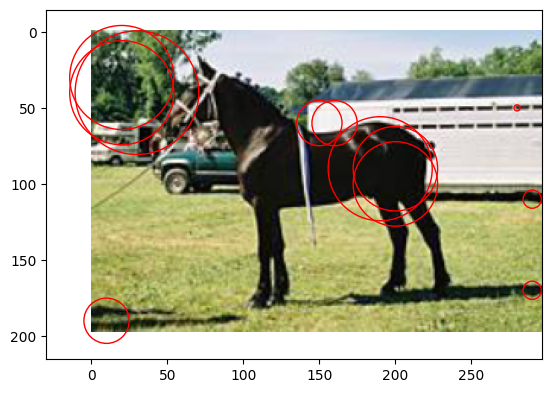

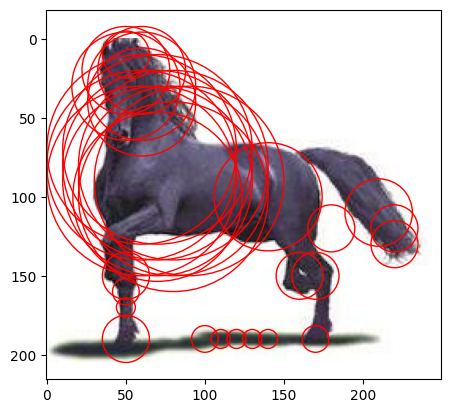

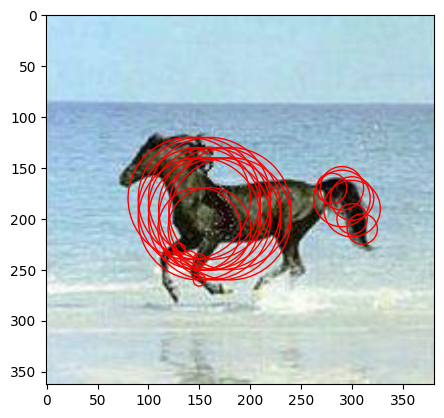

In [6]:
for i, o_img in enumerate(original_images):

    fig, ax = plt.subplots()
    ax.imshow(o_img)

    for blob in positions[i]:

        y, x, r = blob
        c = plt.Circle((x, y), np.sqrt(2)*r, color="red", linewidth=1, fill=False)
        ax.add_patch(c)

    ax.plot()
    plt.show()

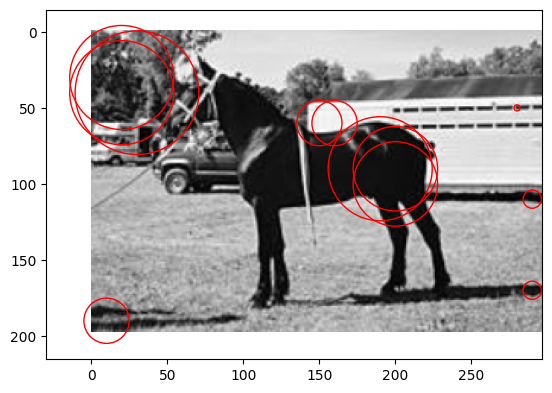

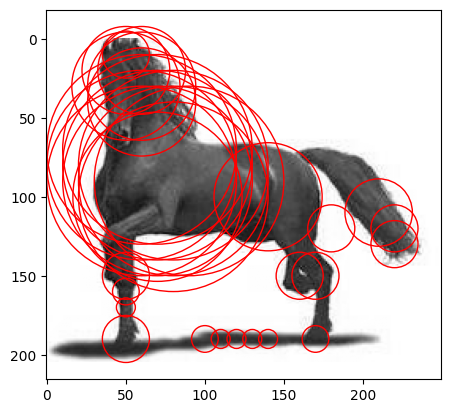

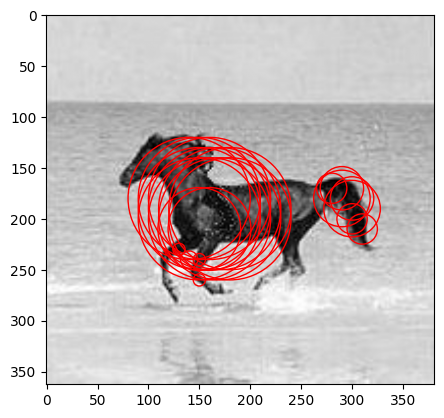

In [7]:
for i, g_img in enumerate(gray_images):

    fig, ax = plt.subplots()
    ax.imshow(g_img, cmap="gray")

    for blob in positions[i]:

        y, x, r = blob
        c = plt.Circle((x, y), np.sqrt(2)*r, color="red", linewidth=1, fill=False)
        ax.add_patch(c)

    ax.plot()
    plt.show()

#### Commentary for results

This section reports results of the analysis with brief commentary. As we can see in the images above, implemented detection is not as great as state-of-the-art solutions. However I think that results are good, because in every image a bigger part of the horse was detected. There was a lot of overlaps in the images. To (at least partially) fix this phenomenon, detection was performed only in every 10th pixel.

>In the first picture, we can see that except the horse, also shadows and part of the tree in the background were detected.

>In the second picture, almost all horse is covered with detected blobs. However horses shadow is detected too.

>In the third picture, there are detected only blobs on the horse.

#### Final section

This is a final section with considerations (fun things, weak aspects, possible ways to enhance the analysis).

Parameter **sigma** has a great influence on the result. With small values of **sigma**, larger blobs cannot be detected and vice versa. Maybe adding more sigmas will result in greater results, but it will also increase computation time. For some pictures is also important if the image values are inverted (*img = 1 - img*) or not.

As funny thing could be considered detection of blobs without 10 pixel gap (exactly with no gap - every pixel). There is so many detected blobs (and drawed circles) that horses are almost invisible behind them sometimes.